<a href="https://colab.research.google.com/github/thdefn/jango/blob/master/usenpycnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd /content/gdrive/My Drive/data/.kaggle

/content/gdrive/My Drive/data/.kaggle


In [5]:
X_valid = np.load('./X_valid_128.npy',allow_pickle=True)
y_valid = np.load('./y_valid_128.npy',allow_pickle=True)
X_train = np.load('./X_train_128.npy',allow_pickle=True)
y_train = np.load('./y_train_128.npy',allow_pickle=True)

In [6]:
X_train = X_train/255
X_valid = X_valid/255

le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)


In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('v1_ag', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
BATCH_SIZE = 16
TRAIN_STEPS = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_valid)//BATCH_SIZE

In [ ]:
train_gen = ImageDataGenerator(
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     vertical_flip=True,
                     horizontal_flip=True,
                     fill_mode='nearest').flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)


# train_gen = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)

In [ ]:
cnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

### 세이빙한 모델 가져오는 부분

In [ ]:
cnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
general = cnn.fit(train_gen, validation_data= valid_gen, epochs= 30, verbose=1,  steps_per_epoch = TRAIN_STEPS, callbacks= [reduceLR, early_stopping, checkpoint_ag]) #피팅
cnn.save('my_imggenmodel2.h5') #모델 세이브

Epoch 1/30
410/410 [==============================] - ETA: 0s - loss: 1.0167 - accuracy: 0.5272
Epoch 1: val_accuracy improved from -inf to 0.52952, saving model to v1_ag


410/410 [==============================] - 38s 71ms/step - loss: 1.0167 - accuracy: 0.5272 - val_loss: 0.9867 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 2/30
410/410 [==============================] - ETA: 0s - loss: 0.9978 - accuracy: 0.5275
Epoch 2: val_accuracy did not improve from 0.52952
410/410 [==============================] - 27s 65ms/step - loss: 0.9978 - accuracy: 0.5275 - val_loss: 0.9760 - val_accuracy: 0.5289 - lr: 0.0010
Epoch 3/30
410/410 [==============================] - ETA: 0s - loss: 0.9849 - accuracy: 0.5257
Epoch 3: val_accuracy did not improve from 0.52952
410/410 [==============================] - 26s 63ms/step - loss: 0.9849 - accuracy: 0.5257 - val_loss: 0.9727 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 4/30
410/410 [==============================] - ETA: 0s - loss: 0.9819 - accuracy: 0.5272
Epoch 4: val_accuracy improved from 0.52952 to 0.53317, saving model to v1_ag


410/410 [==============================] - 27s 66ms/step - loss: 0.9819 - accuracy: 0.5272 - val_loss: 0.9587 - val_accuracy: 0.5332 - lr: 0.0010
Epoch 5/30
410/410 [==============================] - ETA: 0s - loss: 0.9686 - accuracy: 0.5329
Epoch 5: val_accuracy did not improve from 0.53317
410/410 [==============================] - 26s 63ms/step - loss: 0.9686 - accuracy: 0.5329 - val_loss: 0.9576 - val_accuracy: 0.5313 - lr: 0.0010
Epoch 6/30
410/410 [==============================] - ETA: 0s - loss: 0.9640 - accuracy: 0.5280
Epoch 6: val_accuracy improved from 0.53317 to 0.53439, saving model to v1_ag


410/410 [==============================] - 27s 66ms/step - loss: 0.9640 - accuracy: 0.5280 - val_loss: 0.9692 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 7/30
410/410 [==============================] - ETA: 0s - loss: 0.9556 - accuracy: 0.5297
Epoch 7: val_accuracy improved from 0.53439 to 0.54839, saving model to v1_ag


410/410 [==============================] - 27s 65ms/step - loss: 0.9556 - accuracy: 0.5297 - val_loss: 0.9533 - val_accuracy: 0.5484 - lr: 0.0010
Epoch 8/30
410/410 [==============================] - ETA: 0s - loss: 0.9497 - accuracy: 0.5355
Epoch 8: val_accuracy improved from 0.54839 to 0.55569, saving model to v1_ag


410/410 [==============================] - 27s 65ms/step - loss: 0.9497 - accuracy: 0.5355 - val_loss: 0.9448 - val_accuracy: 0.5557 - lr: 0.0010
Epoch 9/30
410/410 [==============================] - ETA: 0s - loss: 0.9484 - accuracy: 0.5330
Epoch 9: val_accuracy did not improve from 0.55569
410/410 [==============================] - 25s 62ms/step - loss: 0.9484 - accuracy: 0.5330 - val_loss: 0.9470 - val_accuracy: 0.5374 - lr: 0.0010
Epoch 10/30
410/410 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.5253
Epoch 10: val_accuracy did not improve from 0.55569
410/410 [==============================] - 25s 62ms/step - loss: 0.9449 - accuracy: 0.5253 - val_loss: 0.9449 - val_accuracy: 0.5484 - lr: 0.0010
Epoch 11/30
410/410 [==============================] - ETA: 0s - loss: 0.9384 - accuracy: 0.5384
Epoch 11: val_accuracy did not improve from 0.55569
410/410 [==============================] - 25s 62ms/step - loss: 0.9384 - accuracy: 0.5384 - val_loss: 0.9460 - val_a

410/410 [==============================] - 30s 74ms/step - loss: 0.9303 - accuracy: 0.5317 - val_loss: 0.9482 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 16/30
410/410 [==============================] - ETA: 0s - loss: 0.9280 - accuracy: 0.5367
Epoch 16: val_accuracy did not improve from 0.55995
410/410 [==============================] - 26s 63ms/step - loss: 0.9280 - accuracy: 0.5367 - val_loss: 0.9349 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 17/30
410/410 [==============================] - ETA: 0s - loss: 0.9290 - accuracy: 0.5355
Epoch 17: val_accuracy did not improve from 0.55995
410/410 [==============================] - 26s 65ms/step - loss: 0.9290 - accuracy: 0.5355 - val_loss: 0.9310 - val_accuracy: 0.5386 - lr: 0.0010
Epoch 18/30
410/410 [==============================] - ETA: 0s - loss: 0.9265 - accuracy: 0.5428
Epoch 18: val_accuracy did not improve from 0.55995
410/410 [==============================] - 26s 63ms/step - loss: 0.9265 - accuracy: 0.5428 - val_loss: 0.9225 - val

410/410 [==============================] - 27s 66ms/step - loss: 0.9162 - accuracy: 0.5420 - val_loss: 0.9234 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 25/30
410/410 [==============================] - ETA: 0s - loss: 0.9170 - accuracy: 0.5401
Epoch 25: val_accuracy did not improve from 0.57091
410/410 [==============================] - 27s 65ms/step - loss: 0.9170 - accuracy: 0.5401 - val_loss: 0.9227 - val_accuracy: 0.5551 - lr: 0.0010
Epoch 26/30
410/410 [==============================] - ETA: 0s - loss: 0.9156 - accuracy: 0.5439
Epoch 26: val_accuracy did not improve from 0.57091
410/410 [==============================] - 27s 65ms/step - loss: 0.9156 - accuracy: 0.5439 - val_loss: 0.9125 - val_accuracy: 0.5514 - lr: 0.0010
Epoch 27/30
410/410 [==============================] - ETA: 0s - loss: 0.9139 - accuracy: 0.5440
Epoch 27: val_accuracy did not improve from 0.57091
410/410 [==============================] - 27s 66ms/step - loss: 0.9139 - accuracy: 0.5440 - val_loss: 0.9133 - val

In [ ]:
cnn = keras.models.load_model('my_imggenmodel5.h5')
cnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
general = cnn.fit(train_gen, validation_data= valid_gen, epochs= 20, verbose=1,  steps_per_epoch = TRAIN_STEPS, callbacks= [reduceLR, checkpoint_ag]) #피팅
cnn.save('my_imggenmodel6.h5') 

Epoch 1/20
410/410 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.5654
Epoch 1: val_accuracy did not improve from 0.59586
410/410 [==============================] - 26s 63ms/step - loss: 0.8844 - accuracy: 0.5654 - val_loss: 0.8887 - val_accuracy: 0.5636 - lr: 0.0010
Epoch 2/20
410/410 [==============================] - ETA: 0s - loss: 0.8693 - accuracy: 0.5686
Epoch 2: val_accuracy did not improve from 0.59586
410/410 [==============================] - 26s 63ms/step - loss: 0.8693 - accuracy: 0.5686 - val_loss: 0.8667 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 3/20
410/410 [==============================] - ETA: 0s - loss: 0.8773 - accuracy: 0.5611
Epoch 3: val_accuracy did not improve from 0.59586
410/410 [==============================] - 25s 62ms/step - loss: 0.8773 - accuracy: 0.5611 - val_loss: 0.8673 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 4/20
410/410 [==============================] - ETA: 0s - loss: 0.8611 - accuracy: 0.5707
Epoch 4: val_accuracy did

410/410 [==============================] - 27s 66ms/step - loss: 0.8632 - accuracy: 0.5782 - val_loss: 0.8546 - val_accuracy: 0.5971 - lr: 0.0010
Epoch 10/20
410/410 [==============================] - ETA: 0s - loss: 0.8574 - accuracy: 0.5768
Epoch 10: val_accuracy did not improve from 0.59708
410/410 [==============================] - 25s 62ms/step - loss: 0.8574 - accuracy: 0.5768 - val_loss: 0.8808 - val_accuracy: 0.5892 - lr: 0.0010
Epoch 11/20
410/410 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.5771
Epoch 11: val_accuracy did not improve from 0.59708
410/410 [==============================] - 26s 63ms/step - loss: 0.8585 - accuracy: 0.5771 - val_loss: 0.8578 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 12/20
410/410 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.5715
Epoch 12: val_accuracy did not improve from 0.59708
410/410 [==============================] - 25s 62ms/step - loss: 0.8605 - accuracy: 0.5715 - val_loss: 0.8572 - val

410/410 [==============================] - 27s 65ms/step - loss: 0.8517 - accuracy: 0.5794 - val_loss: 0.8436 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 17/20
410/410 [==============================] - ETA: 0s - loss: 0.8542 - accuracy: 0.5808
Epoch 17: val_accuracy improved from 0.59769 to 0.59890, saving model to v1_ag


410/410 [==============================] - 27s 65ms/step - loss: 0.8542 - accuracy: 0.5808 - val_loss: 0.8565 - val_accuracy: 0.5989 - lr: 0.0010
Epoch 18/20
410/410 [==============================] - ETA: 0s - loss: 0.8545 - accuracy: 0.5825
Epoch 18: val_accuracy did not improve from 0.59890
410/410 [==============================] - 26s 62ms/step - loss: 0.8545 - accuracy: 0.5825 - val_loss: 0.8647 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 19/20
410/410 [==============================] - ETA: 0s - loss: 0.8416 - accuracy: 0.5919
Epoch 19: val_accuracy did not improve from 0.59890
410/410 [==============================] - 25s 62ms/step - loss: 0.8416 - accuracy: 0.5919 - val_loss: 0.8646 - val_accuracy: 0.5788 - lr: 0.0010
Epoch 20/20
410/410 [==============================] - ETA: 0s - loss: 0.8556 - accuracy: 0.5756
Epoch 20: val_accuracy did not improve from 0.59890
410/410 [==============================] - 27s 65ms/step - loss: 0.8556 - accuracy: 0.5756 - val_loss: 0.8501 - val

In [ ]:
with open('history.pkl', 'rb') as f:
	df = pickle.load(f)

In [ ]:
 for i in range(len(general.history['loss'])):
    df['loss'].append(general.history['loss'][i])
    df['accuracy'].append(general.history['accuracy'][i])
    df['val_loss'].append(general.history['val_loss'][i])
    df['val_accuracy'].append(general.history['val_accuracy'][i])

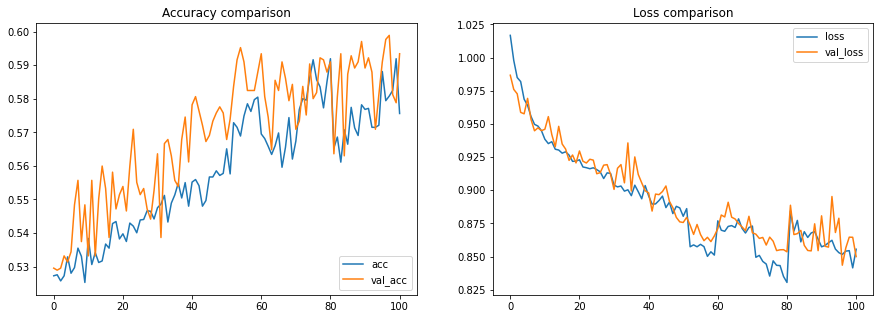

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='acc')
plt.plot(df['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

In [ ]:
import pickle

with open('history.pkl', 'wb') as f:
	pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('history.pkl', 'rb') as f:
	df = pickle.load(f)

In [7]:
cnn = keras.models.load_model('my_imggenmodel6.h5')

In [18]:
y_pred_enc = cnn.predict(x_valid)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_valid, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,Type 1,Type 2,Type 3
Type 1,51,211,26
Type 2,19,729,122
Type 3,5,285,195
